# Clustering 
* #### k-means
* #### pc analysis

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from haversine import haversine, Unit

## Data Reading

In [2]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

duesseldorf = read_data("duesseldorf").dropna(axis=0)
bremen = read_data("bremen").dropna(axis=0)

# Calcuation K-Means-1 
#### Method definitions

In [3]:
def distance_between_coordinates (trip_data, city_center_lat,city_center_lng):
    trip_data["distance_from_center_start"] = trip_data.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
    trip_data["distance_from_center_end"] = trip_data.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
    X = trip_data.drop(["day","time","b_number","city","trip_duration","orig_lat","orig_lng","dest_lat","dest_lng","avg_speed","rounded_time_hourly","temp","wind","rain","fleetsize_weekly","fleetsize_monthly","fleetsize_dayly","Unnamed: 0","datetime_start","datetime_end","weekday","month","hour","week"], axis=1)
    X.drop(["distance"],axis=1,inplace=True)
    return X   


def calc_revenue(x):
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
        
        
def revenue_distance_from_center (trip_data, city_center_lat,city_center_lng):
    trip_data["distance_from_center_start"] = trip_data.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
    trip_data["distance_from_center_end"] = trip_data.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
    X = trip_data.drop(["day","time","b_number","city","trip_duration_hours","orig_lat","orig_lng","dest_lat","dest_lng","avg_speed","rounded_time_hourly","temp","wind","rain","fleetsize_weekly","fleetsize_monthly","fleetsize_dayly","Unnamed: 0","datetime_start","datetime_end","weekday","month","hour","week"], axis=1)
    X["revenue"] = X["trip_duration"].apply(lambda x: calc_revenue(x) )
    X.drop(["distance","trip_duration"],axis=1,inplace=True)
    return X   

def normalize(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    # create a df out of array
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    X_scaled_df.head()
    return X_scaled_df


def determine_k(X_scaled):
    k_max = 50
    clusters = []
    losses = []
    for k in range(k_max):
        model = KMeans(n_clusters=k+1)
        model.fit(X_scaled)
        clusters.append(k+1)
        losses.append(model.inertia_)
        
    plt.plot(clusters, losses)
    plt.show()    
    plt.plot(clusters, losses)
    plt.xlim([0,15])

def plot_kmeans(name, X,X_scaled,k):
    # refit algorithm
    two_means = KMeans(n_clusters=k)
    two_means.fit(X_scaled)

    # match records to clusters by calling predict
    two_means.predict(X_scaled)
    numbers = ["zero", "one", "two", "three", "five"]
    X["clusters"] = two_means.predict(X_scaled)
    X["clusters"] = X["clusters"].apply(lambda x: numbers[x])
  #  test = X[X["distance_from_center_start"]<20]
    sns_plot = sns.pairplot(data=X, hue="clusters", height = 20)
    sns_plot.savefig("Project_Data/Graphics/Cluster/" + "k_means_"+ name + ".pdf")       

# Plotting K-Means 
# @Simon Intepretation

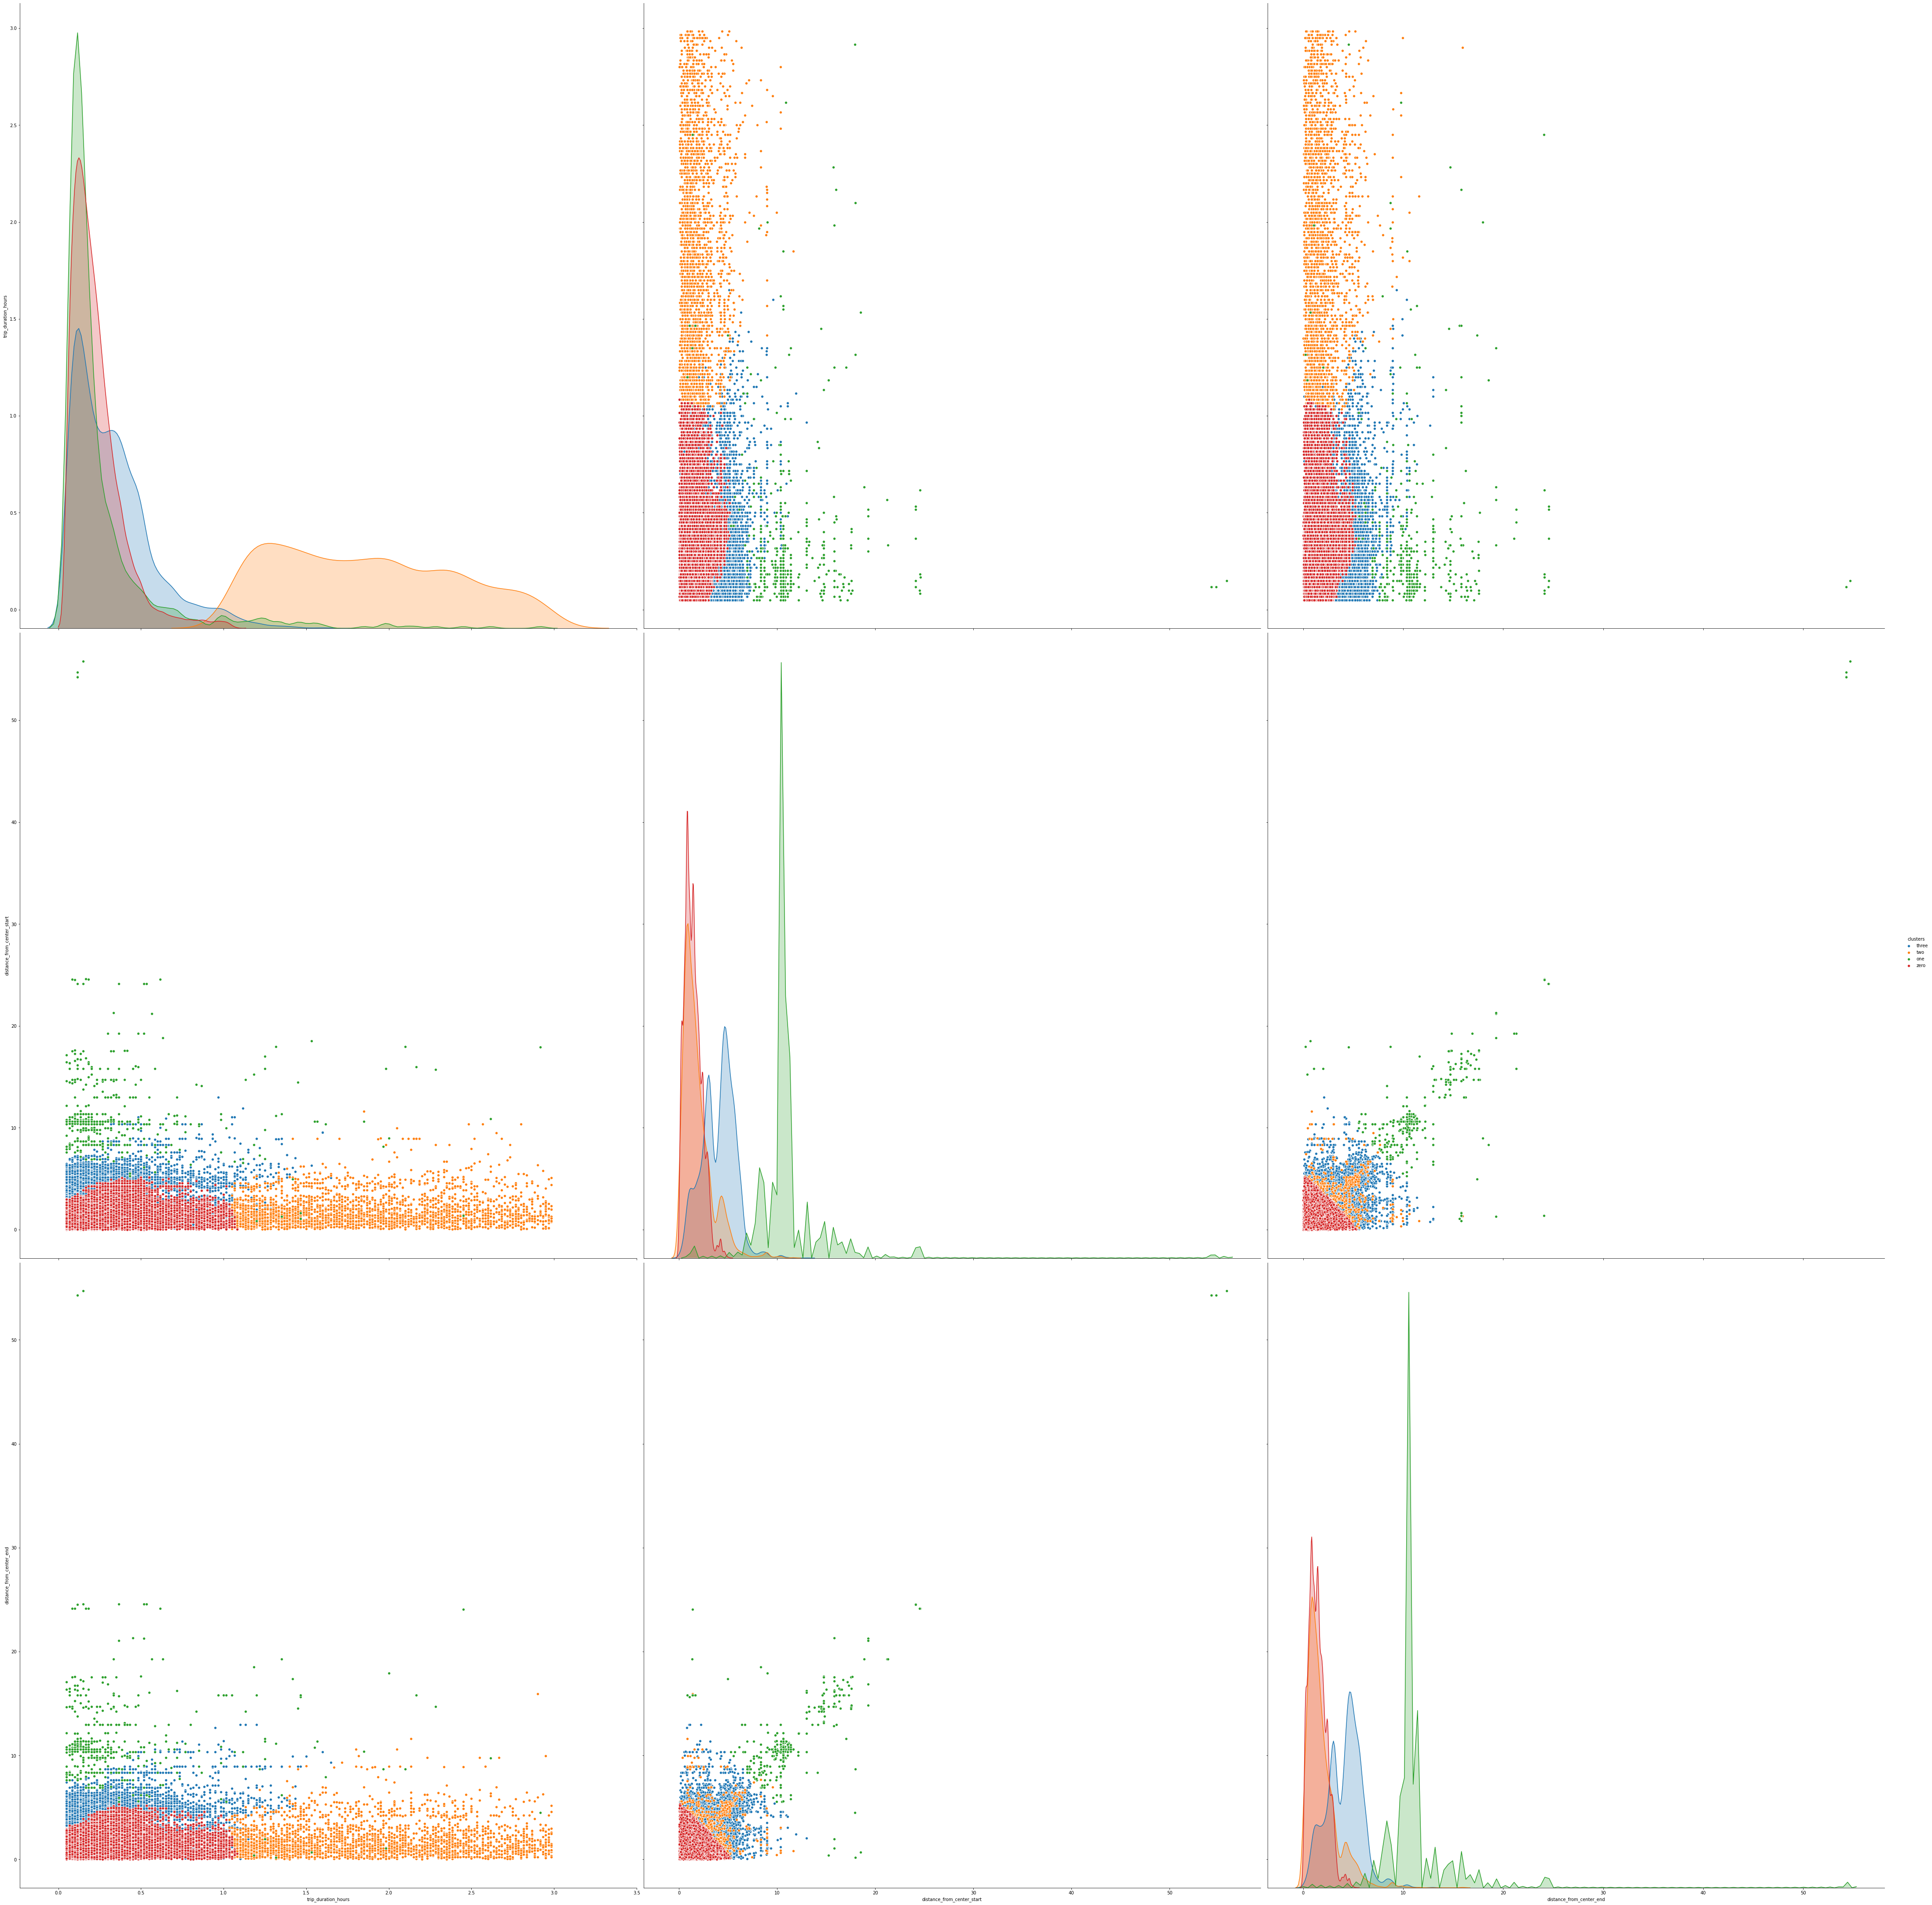

In [4]:
bremen = read_data("bremen")
bremen_d = distance_between_coordinates(bremen,53.075878, 8.807311)
normalized_bremen = normalize(bremen_d)
#determine_k(normalized_bremen)
# k=4
plot_kmeans("bremen_d", bremen_d,normalized_bremen,4)

@Simon

C:\Users\jan_p\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\jan_p\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\jan_p\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


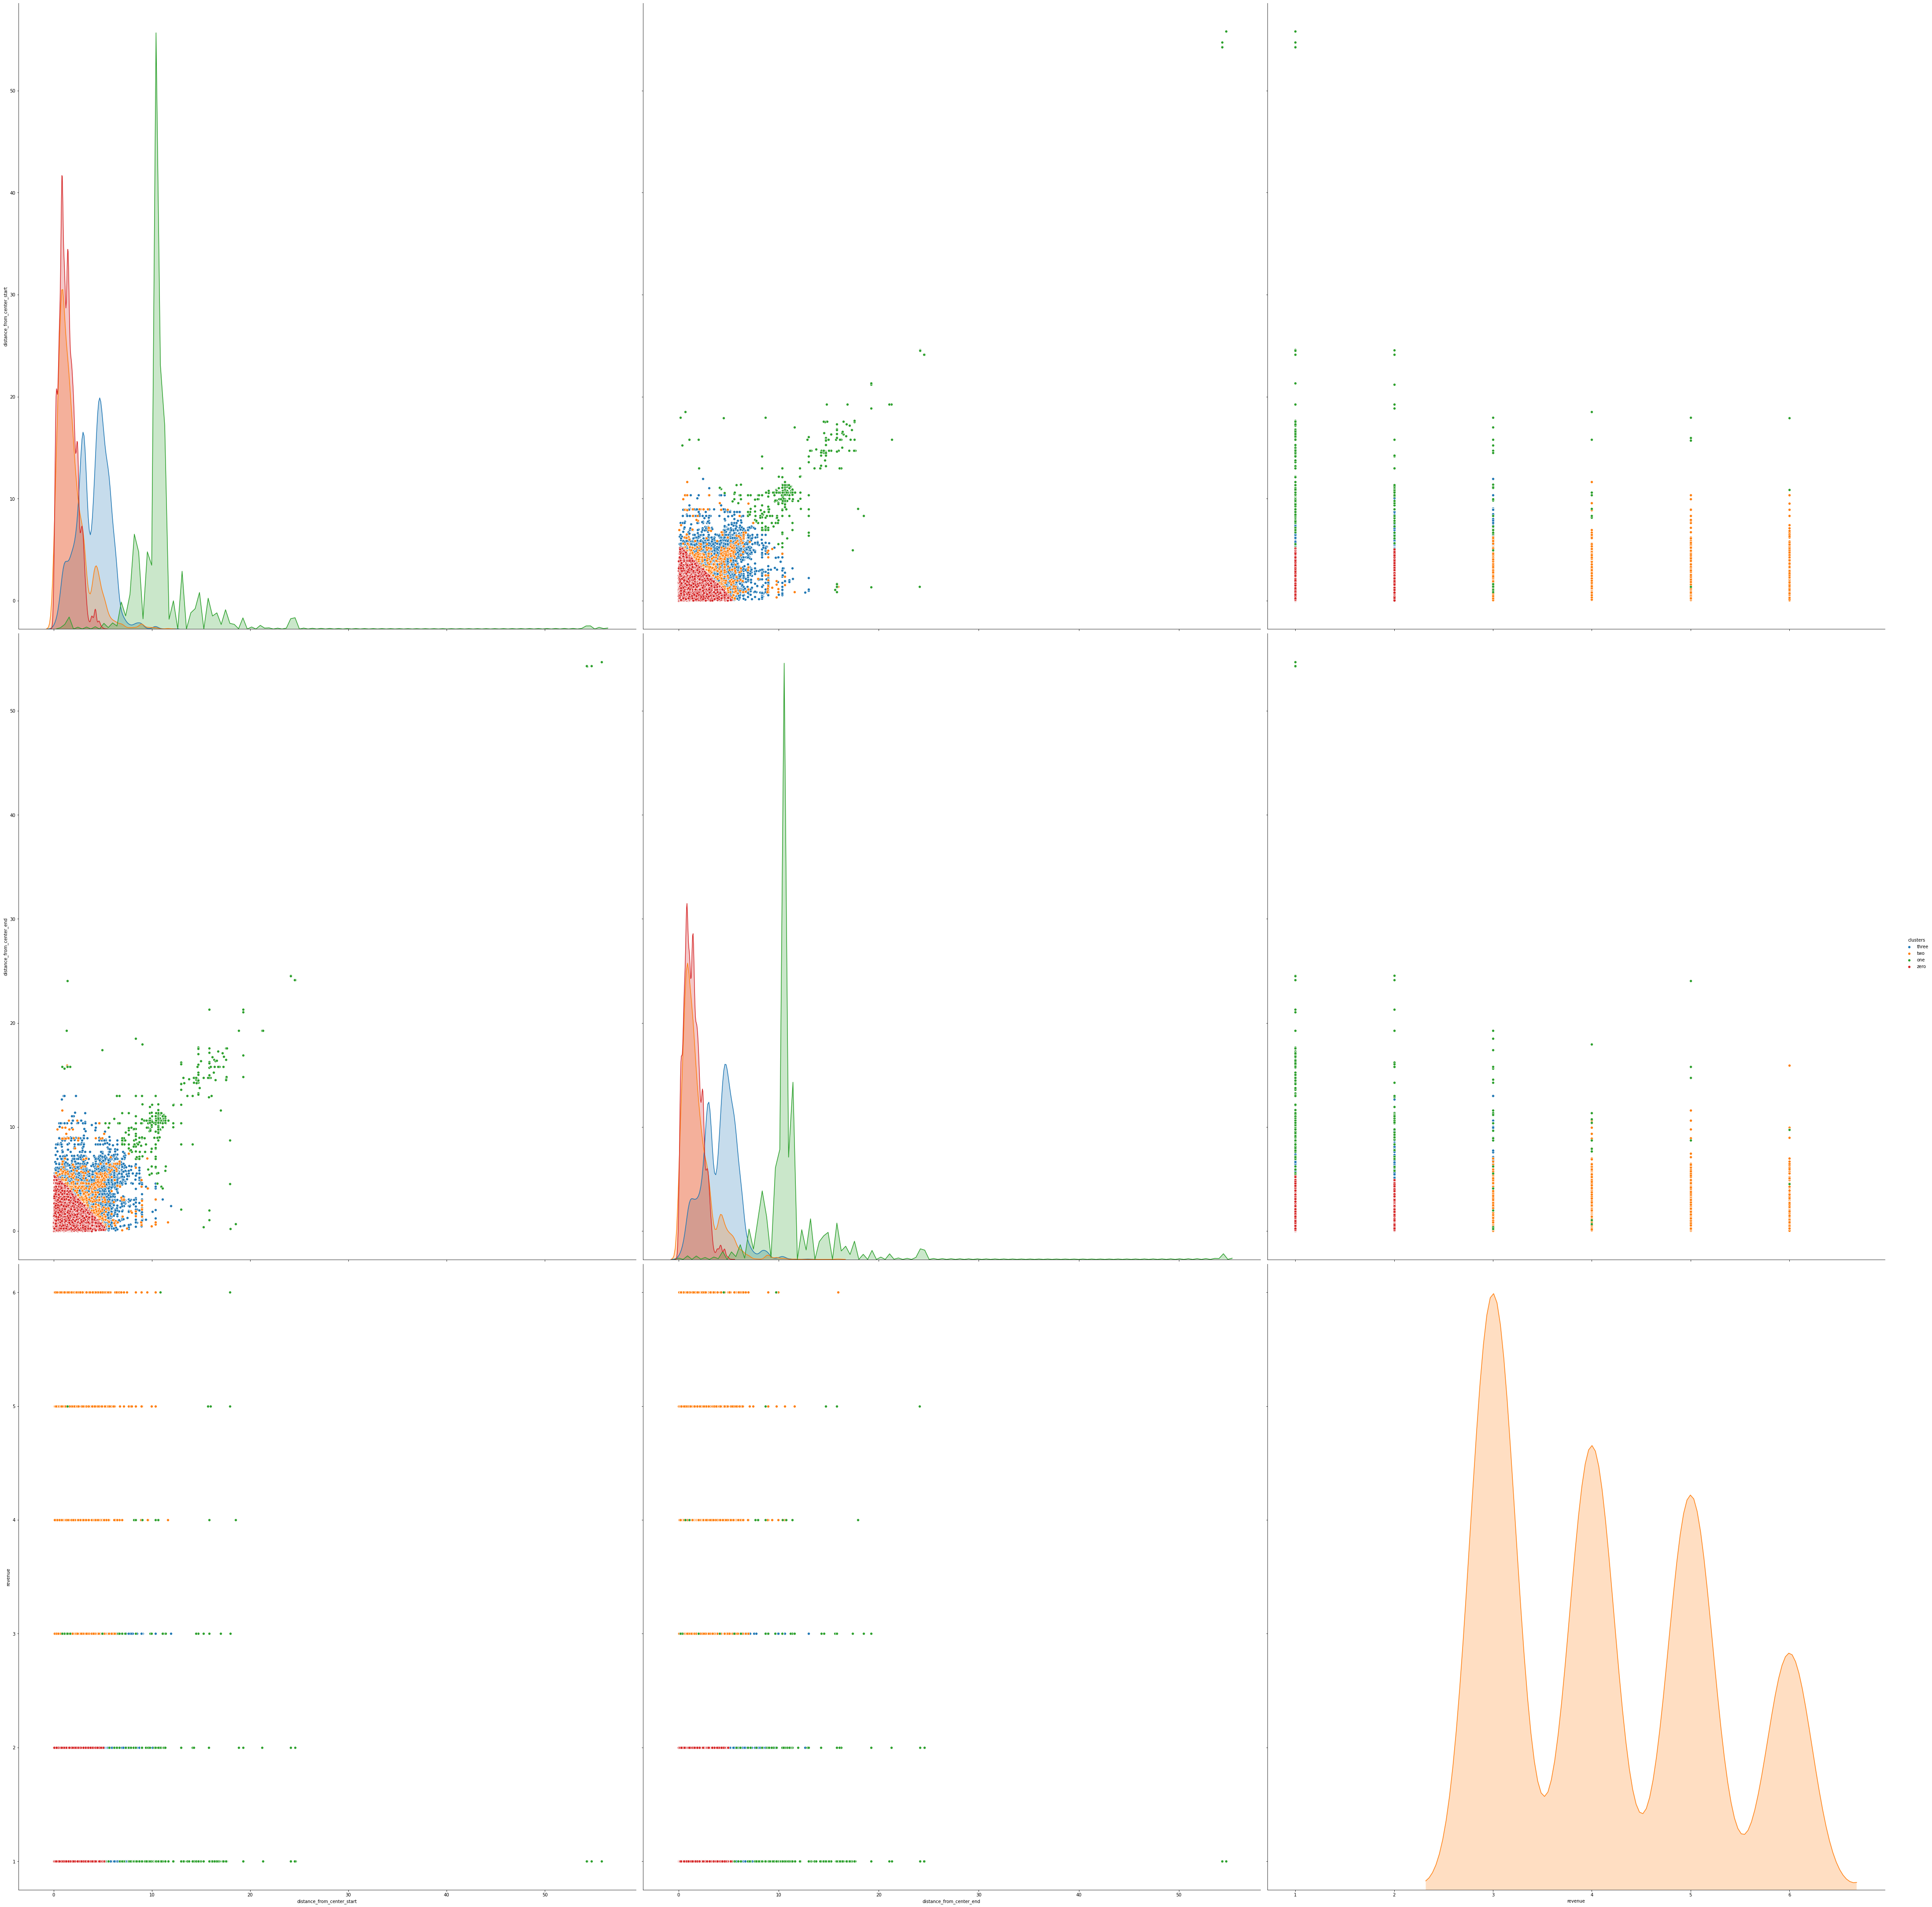

In [5]:
bremen_d_2 = revenue_distance_from_center(bremen,53.075878, 8.807311)
normalized_bremen_2 = normalize(bremen_d_2)
#determine_k(normalized_bremen_2)
# k=4
plot_kmeans("bremen_d_2" ,bremen_d_2,normalized_bremen_2,4)

# Calculation K-Means-2 Duesseldorf
### domain knowledge based clustering
Based on our findings in the KPI analysis, we decided to delete values, so we could investigate the intuitive input features (influence of temperature/hour).

The analysis of the data for Bremen did not show any meaningful results with the data selected in this step.
## Data Prep and Scaling

In [6]:
X = duesseldorf.drop(["day", "time", "city", "trip_duration", "rounded_time_hourly",
                     "datetime_start", "datetime_end", "rounded_time_hourly", "Unnamed: 0",
                     "b_number", "avg_speed", "fleetsize_weekly", "fleetsize_monthly", "fleetsize_dayly",
                     "week", "orig_lat", "orig_lng", "dest_lat", "dest_lng", "weekday", "month",
                     "wind", "rain"], axis=1)

In [7]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
duesseldorf_scaled = X_scaled_df
X_scaled_df.head()

,hour,distance,trip_duration_hours,temp
0,0.321583,0.590130,-0.319682,-1.367538
1,0.321583,0.290374,-0.133326,-1.253682
2,-0.073763,-0.287542,1.637061,-0.015502
3,-1.457475,1.351653,-0.164385,-2.036440
4,0.123910,-0.383103,-0.474979,-0.940579


## Determination of the optimal k-value

array([0, 0, 0, ..., 1, 1, 1])

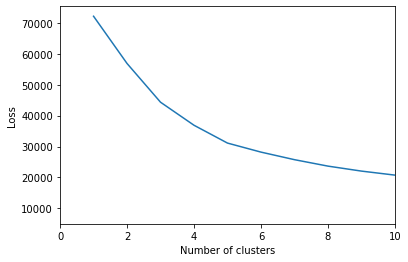

In [8]:
k_max = 50 

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)
    
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

# refit algorithm
two_means = KMeans(n_clusters=2)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

# Plotting K-Means 3-Cluster
# @jan Intepretation

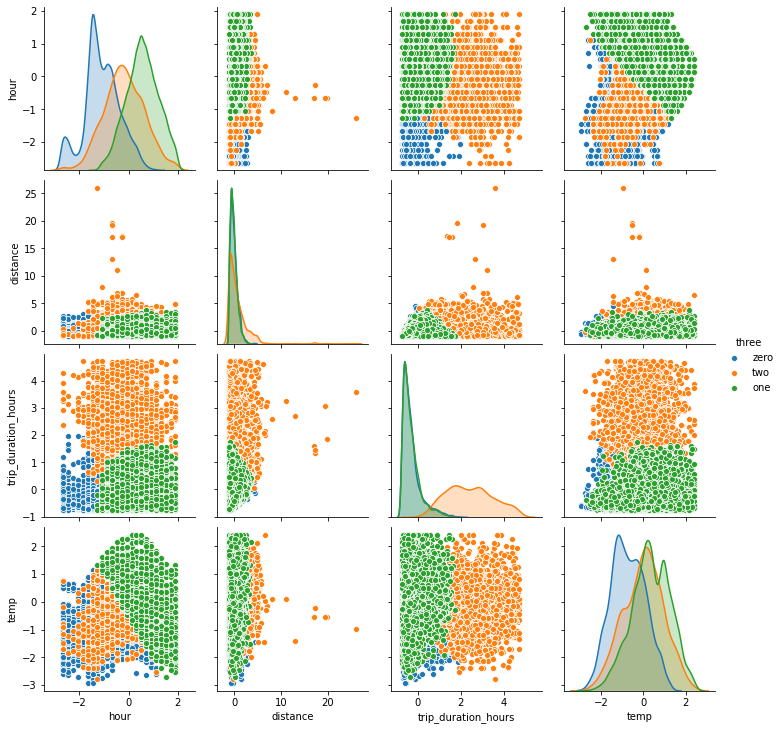

In [10]:
numbers = ["zero", "one", "two", "three"]

three_means = KMeans(n_clusters=3)
three_means.fit(X_scaled)
duesseldorf_scaled["three"] = three_means.predict(X_scaled)
duesseldorf_scaled["three"] = duesseldorf_scaled["three"].apply(lambda x: numbers[x])
sns_plot_3 = sns.pairplot(data=duesseldorf_scaled, hue="three")
sns_plot_3.savefig("Project_Data/Graphics/Cluster/" + "k_means_"+ "duesseldorf_3_cluster" + ".pdf")       

# Plotting K-Means 2-Cluster
The optimal k-value is 3, but this was very difficult to interpret in the analysis (see above). When looking at two clusters, clearly more conclusions can be drawn. It is particularly noticeable that the orange cluster is more likely to be assigned to the afternoon and the blue cluster to the morning. Logically, the temperature correlates with this. Interestingly, all outliers are assigned to the blue cluster. 
# @jan Intepretation

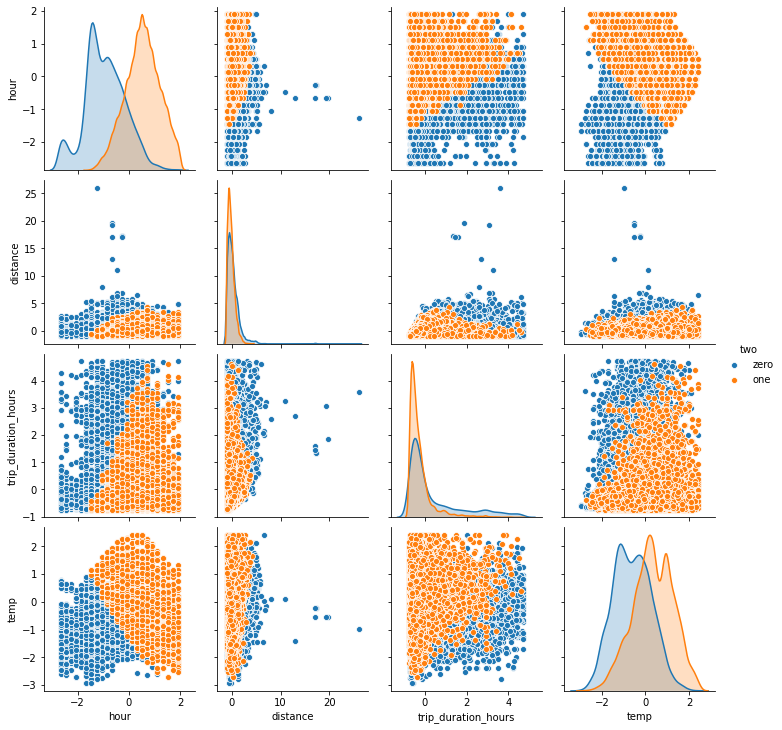

In [11]:
duesseldorf_scaled["two"] = two_means.predict(X_scaled)
duesseldorf_scaled["two"] = duesseldorf_scaled["two"].apply(lambda x: numbers[x])
sns_plot_2 = sns.pairplot(data=duesseldorf_scaled, hue="two")
sns_plot_2.savefig("Project_Data/Graphics/Cluster/" + "k_means_"+ "duesseldorf_2_cluster" + ".pdf")       

# PCA Analysis
# @jan Intepretation
The analysis of the data for Bremen did not show any meaningful results with the data selected in this step, so we foccused on the prediction models.
## Data Prep and Scaling

In [12]:
bremen_wo_target = bremen.drop(["day", "time", "city", "trip_duration", "rounded_time_hourly",
                     "datetime_start", "datetime_end", "rounded_time_hourly", "Unnamed: 0",
                       "fleetsize_weekly", "fleetsize_monthly", "fleetsize_dayly"
                     ], axis=1)
scaler = StandardScaler()

bremen_scaled = pd.DataFrame(scaler.fit_transform(bremen_wo_target))


## Determination of the number of components

In [13]:
pca = PCA(n_components=12)
bremen_scaled_pca = pca.fit_transform(bremen_scaled)

#### selection 12 out of 14 columns can explain 0,96% of variance

In [14]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.15917179 0.14171865 0.10416442 0.08946161 0.07103374 0.06516014
 0.06097539 0.05820987 0.05797832 0.04987394 0.04835948 0.03070173]
0.9368090876851211


## Calculation of optimal cluster number

(0.0, 10.0)

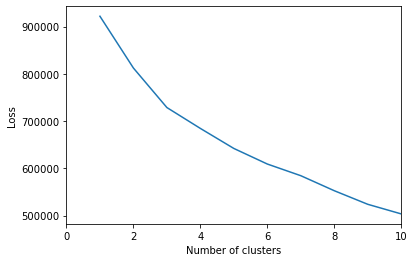

In [15]:
clusters = []
losses = []
k_max = 10

for i in range(k_max):
    model = KMeans(n_clusters=i+1)
    model.fit(bremen_scaled_pca)
    clusters.append(i+1)
    losses.append(model.inertia_)
    
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

# KMeans cluster analysis with 5 clusters

In [16]:
bremen_five = KMeans(n_clusters=5)
bremen_five.fit(bremen_scaled_pca)

bremen_five.predict(bremen_scaled_pca)

bremen_scaled_pca_df = pd.DataFrame(bremen_scaled_pca, index=bremen.index)
bremen_scaled_pca_df.columns = ["PC"+str(column+1) for column in bremen_scaled_pca_df.columns]

bremen_scaled_pca_df["Cluster"] = bremen_five.predict(bremen_scaled_pca)
bremen_scaled_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Cluster
0,2.335055,3.561294,-0.755480,1.547764,-0.311397,-1.845040,-0.704972,1.930588,0.083392,0.275537,0.041477,0.413354,4
1,2.635549,2.379687,-0.918689,1.095186,0.701878,-1.483790,0.184245,1.552998,-0.404512,0.533562,-0.635951,-0.315810,4
2,3.257370,2.136656,-1.043111,1.016794,1.000450,-0.793749,-0.971915,1.942458,-0.126176,0.316450,-0.039097,-0.460183,4
3,3.819405,1.732414,-1.020932,3.713282,-2.651981,-0.062291,1.149071,1.038418,-0.065673,-0.755278,-0.495746,0.372728,0
4,4.116002,2.137134,-1.076003,4.415092,-2.633338,0.646071,0.959605,1.038920,-0.069965,-0.951110,-0.379877,0.157720,0


## Cluster for the most relevant varinace factors PC1, PC2 and PC3
# @jan Intepretation
#### PC1 and PC2

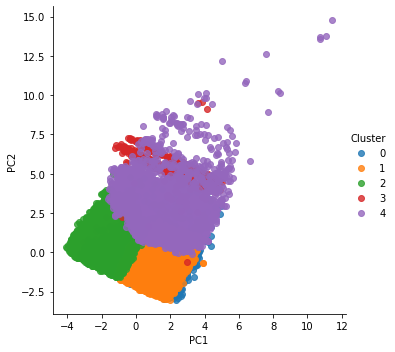

In [17]:
sns_pc_plot1 = sns.lmplot(x="PC1", y="PC2", data=bremen_scaled_pca_df, fit_reg=False, hue="Cluster")
sns_pc_plot1.savefig("Project_Data/Graphics/Cluster/" + "sns_pc_plot1" + ".pdf")       

#### PC2 and PC3

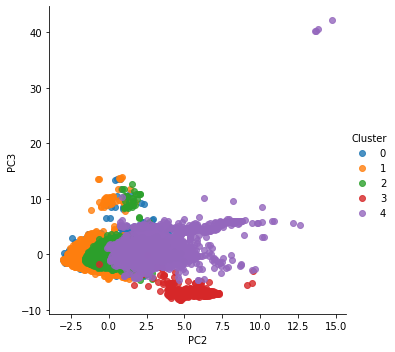

In [18]:
sns_pc_plot2 = sns.lmplot(x="PC2", y="PC3", data=bremen_scaled_pca_df, fit_reg=False, hue="Cluster")
sns_pc_plot2.savefig("Project_Data/Graphics/Cluster/"+ "sns_pc_plot2" + ".pdf")       

# KMeans cluster analysis with 3 clusters

In [19]:
bremen_three = KMeans(n_clusters=3)
bremen_three.fit(bremen_scaled_pca)

bremen_three.predict(bremen_scaled_pca)

bremen_scaled_pca_df = pd.DataFrame(bremen_scaled_pca, index=bremen.index)
bremen_scaled_pca_df.columns = ["PC"+str(column+1) for column in bremen_scaled_pca_df.columns]

bremen_scaled_pca_df["Cluster"] = bremen_three.predict(bremen_scaled_pca)
bremen_scaled_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Cluster
0,2.335055,3.561294,-0.755480,1.547764,-0.311397,-1.845040,-0.704972,1.930588,0.083392,0.275537,0.041477,0.413354,2
1,2.635549,2.379687,-0.918689,1.095186,0.701878,-1.483790,0.184245,1.552998,-0.404512,0.533562,-0.635951,-0.315810,2
2,3.257370,2.136656,-1.043111,1.016794,1.000450,-0.793749,-0.971915,1.942458,-0.126176,0.316450,-0.039097,-0.460183,2
3,3.819405,1.732414,-1.020932,3.713282,-2.651981,-0.062291,1.149071,1.038418,-0.065673,-0.755278,-0.495746,0.372728,2
4,4.116002,2.137134,-1.076003,4.415092,-2.633338,0.646071,0.959605,1.038920,-0.069965,-0.951110,-0.379877,0.157720,2


## Cluster for the most relevant varinace factors PC1, PC2 and PC3
# @jan Intepretation
#### PC1 and PC2

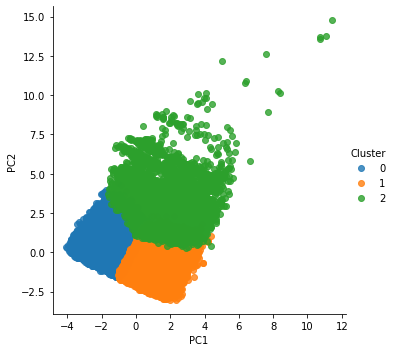

In [20]:
sns_pc_plot3 = sns.lmplot(x="PC1", y="PC2", data=bremen_scaled_pca_df, fit_reg=False, hue="Cluster")
sns_pc_plot3.savefig("Project_Data/Graphics/Cluster/"+ "sns_pc_plot3" + ".pdf")       

#### PC2 and PC3

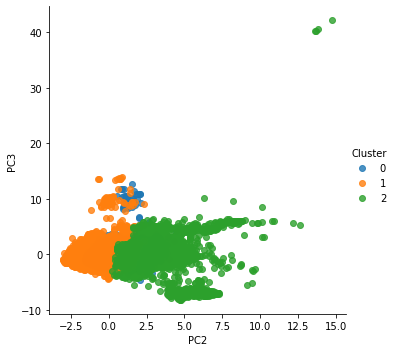

In [21]:
sns_pc_plot4 = sns.lmplot(x="PC2", y="PC3", data=bremen_scaled_pca_df, fit_reg=False, hue="Cluster")
sns_pc_plot4.savefig("Project_Data/Graphics/Cluster/" + "sns_pc_plot4" + ".pdf")       